## Advanced Lane Finding Project
The goals / steps of this project are the following: <br>

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.<br>
* Apply a distortion correction to raw images.<br>
* Use color transforms, gradients, etc., to create a thresholded binary image.<br>
* Apply a perspective transform to rectify binary image ("birds-eye view").<br>
* Detect lane pixels and fit to find the lane boundary.<br>
* Determine the curvature of the lane and vehicle position with respect to center.<br>
* Warp the detected lane boundaries back onto the original image.<br>
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.<br>

## 1. Camera calibration and distortion correction


In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.image as mpimg

%matplotlib qt

In [2]:
def calibrate_camera(images, nx=9, ny=6):
   
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # nx = Number of inside corners in x
    # ny = Number of inside corners in y
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        


In [3]:
# Make a list of calibration images
img = []
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

## 2. Distortion Correction


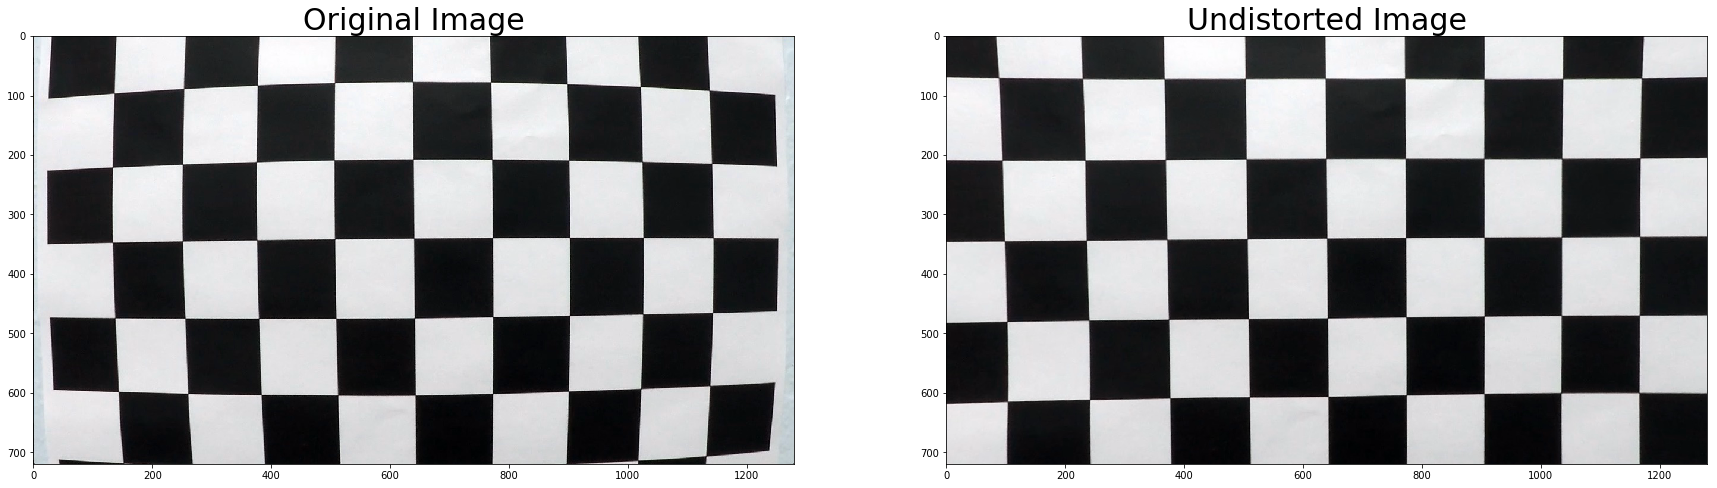

In [4]:
# Undistort a test image
img = cv2.imread('./camera_cal/calibration1.jpg')

undistort_img = cv2.undistort(img, mtx, dist, None, mtx)

# Plot the result, the images.
def print_images(img1, text1, img2, text2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
    ax1.set_title(text1, fontsize=30)
    ax1.imshow(img1)
    ax2.set_title(text2, fontsize=30)
    ax2.imshow(img2, cmap='gray')
    
print_images(img, 'Original Image', undistort_img, 'Undistorted Image')
#mpimg.imsave('./output_images/undistort_img.jpg', undistort_img)

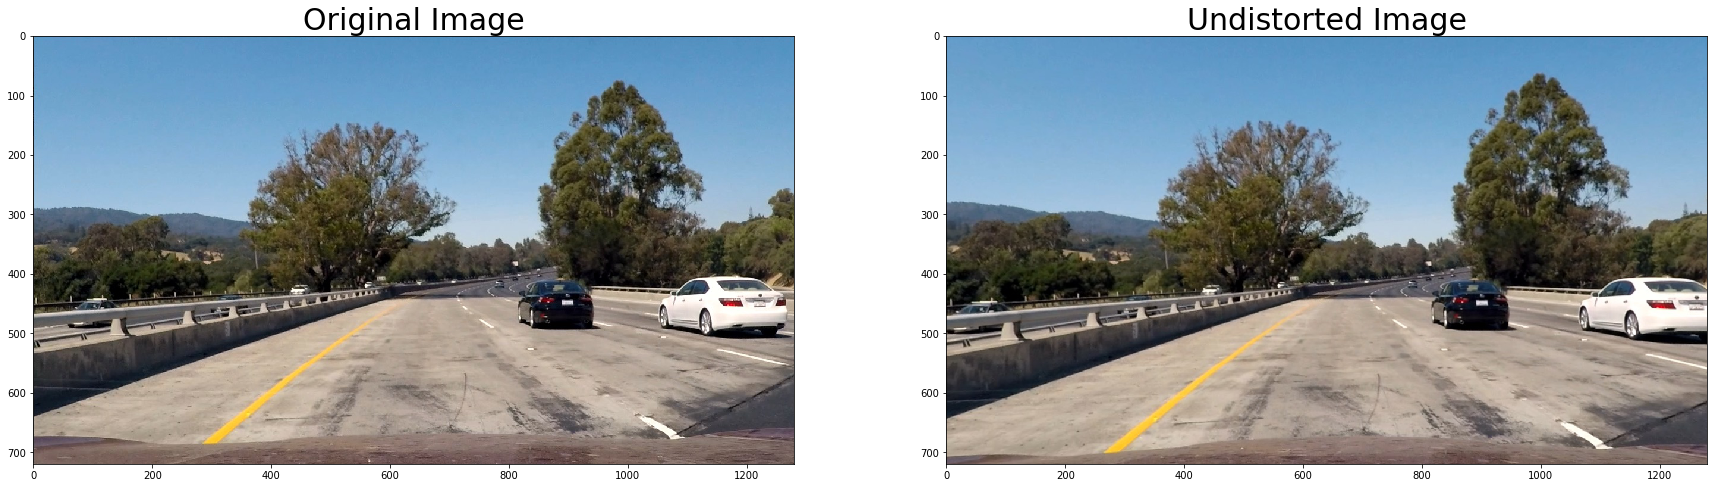

In [5]:
# Test undistortion on an street image
orig_img = cv2.imread('./test_images/test1.jpg',1)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(orig_img, mtx, dist, None, mtx)
print_images(orig_img, 'Original Image', undistorted, 'Undistorted Image')
#mpimg.imsave('./output_images/undistort_street.jpg', undistorted)

In [6]:

# Load a test image, convert to RGB and undistort it
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)


## 3. Creating thresholded Binary Images

In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

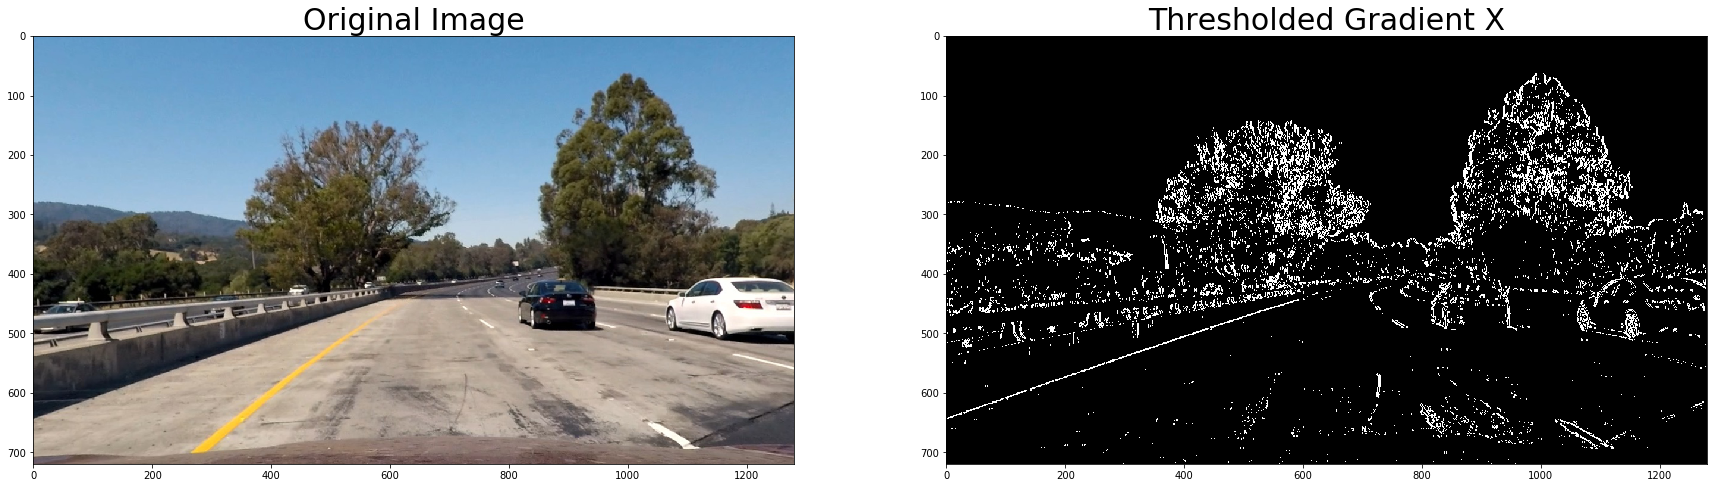

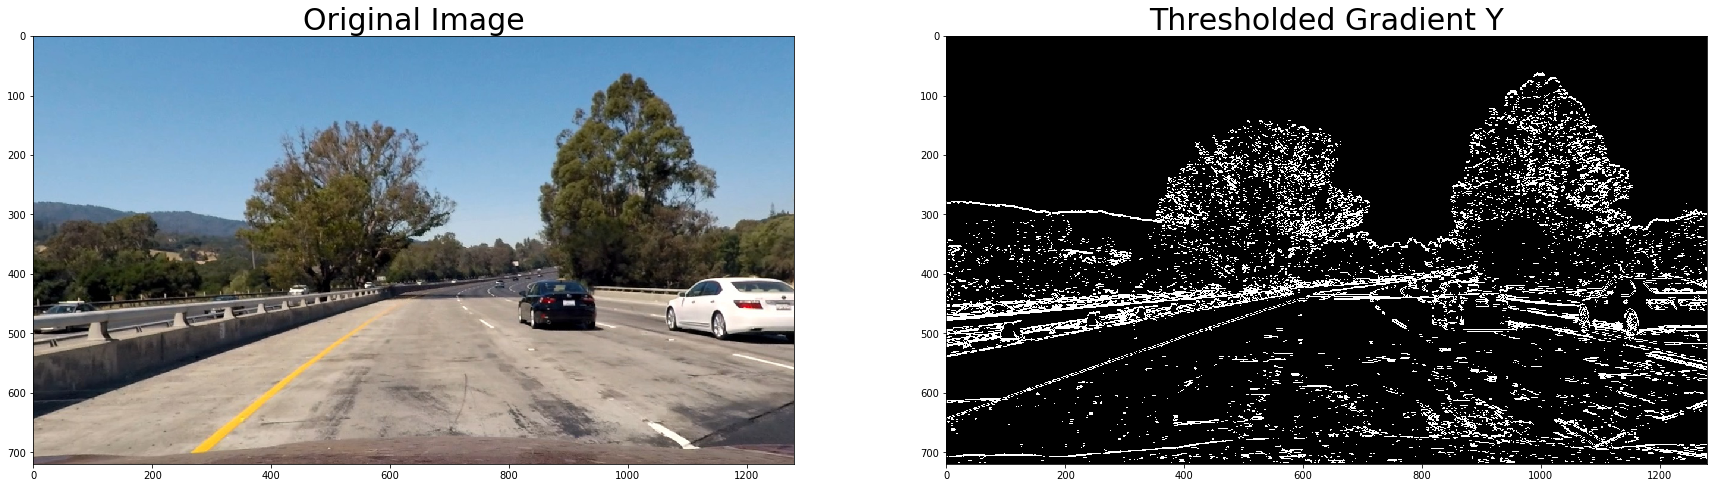

In [8]:
# Run the functions
sobel_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(20, 100))
sobel_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh=(20, 100))


# Plot the results
print_images(img, 'Original Image', sobel_x, 'Thresholded Gradient X')
print_images(img, 'Original Image', sobel_y, 'Thresholded Gradient Y')

mpimg.imsave('./output_images/Thresholded_Gradient_X.jpg', sobel_x)
#mpimg.imsave('./output_images/Thresholded_Gradient_Y.jpg', sobel_y)

In [9]:
# Calculate gradient magnitude
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thres(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

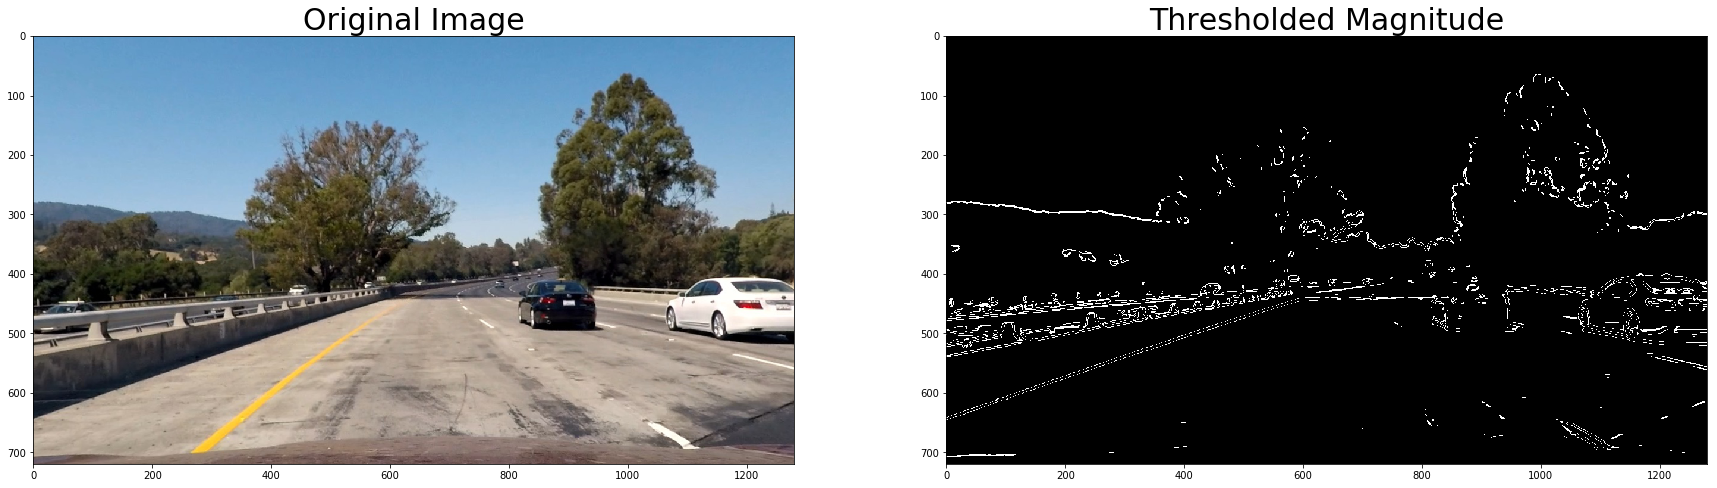

In [10]:
# Run the function
mag_binary = mag_thres(img, sobel_kernel=15, thresh=(70, 100))

# Show images
print_images(img, 'Original Image', mag_binary, 'Thresholded Magnitude')
#mpimg.imsave('./output_images/Thresholded_Magnitude.jpg', mag_binary)

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

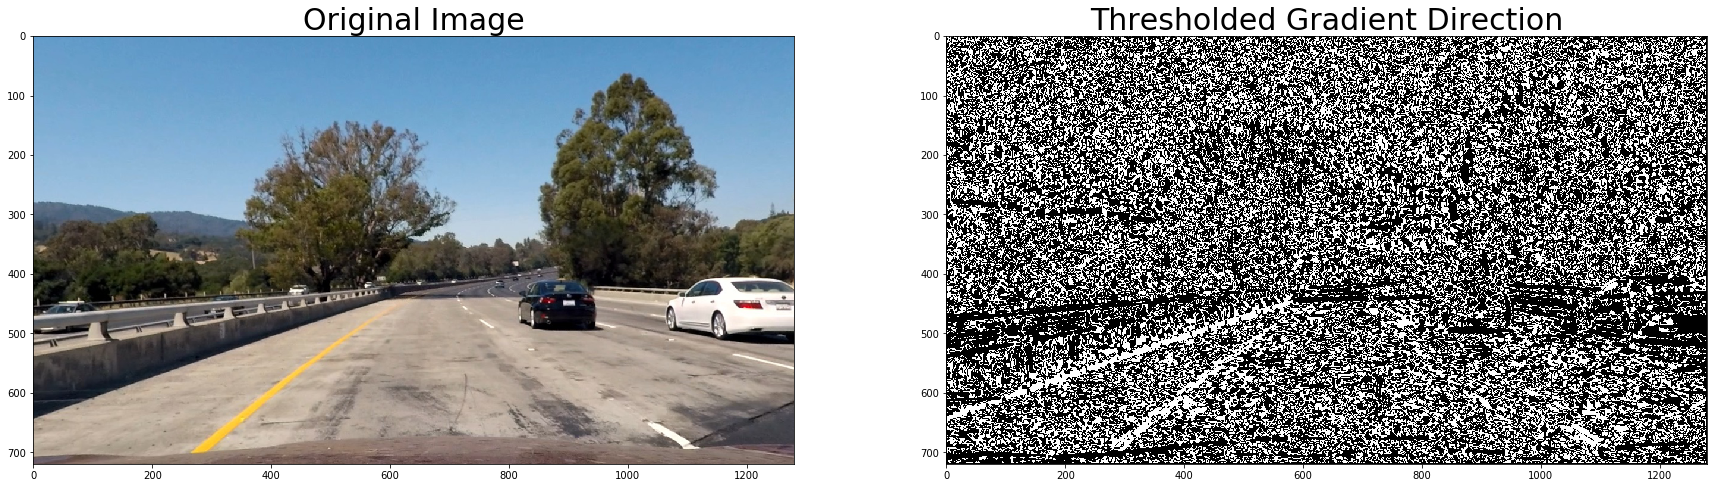

In [12]:
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
print_images(img, 'Original Image', dir_binary, 'Thresholded Gradient Direction')
#mpimg.imsave('./output_images/Thresholded_Gradient_Direction.jpg', dir_binary)

In [13]:
'''
Calculate color threshold
HLS Thresholding
Hue, Lightness, Saturation
'''
def hls_thresh(img, thresh=(150, 255)):
    # HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel, usually the best performant for this task. 
    s = hls[:,:,2] 
    l = hls[:,:,1]
    
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1

    # Return the binary image
    return binary_output

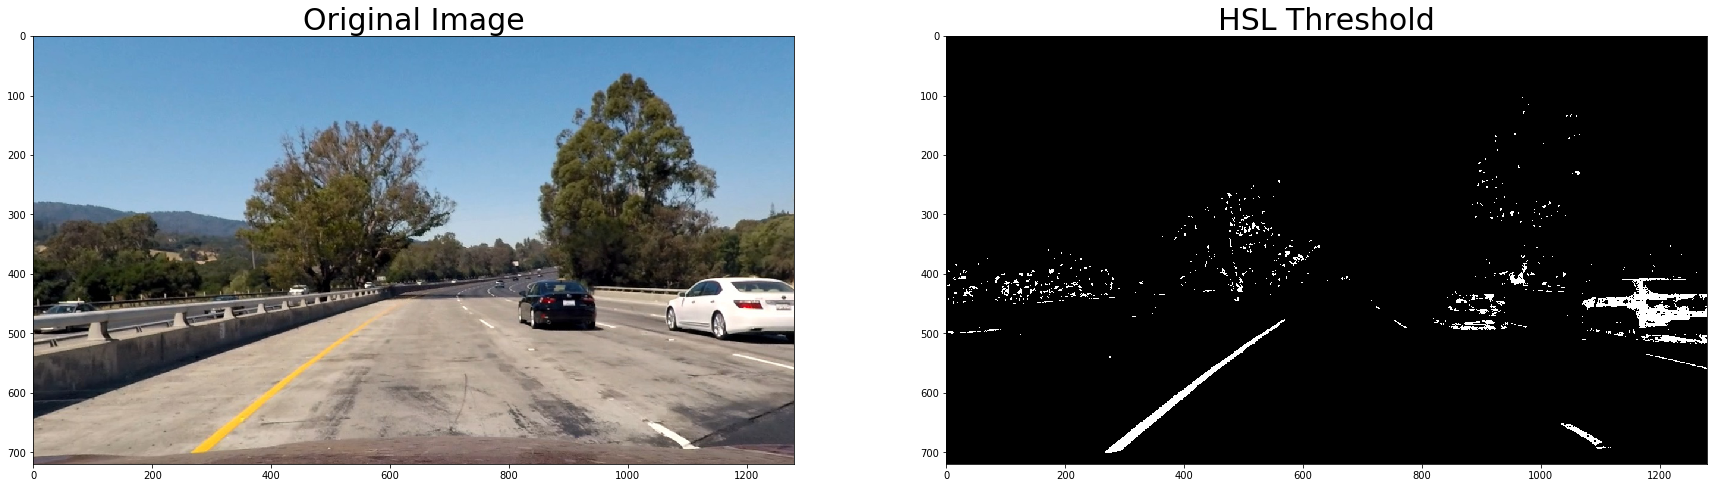

In [14]:
hls_binary = hls_thresh(img, thresh=(170, 255))

print_images(img, 'Original Image', hls_binary, 'HSL Threshold')
#mpimg.imsave('./output_images/HSL_Threshold.jpg', hls_binary)

 ## 4. Combine thresholds to detect the line

In [15]:
def threshold_combined(sobel_x, sobel_y, mag_binary, dir_binary, hls_binary):
    # Combine the previous thresholds
    combined = np.zeros_like(dir_binary)
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

    return combined

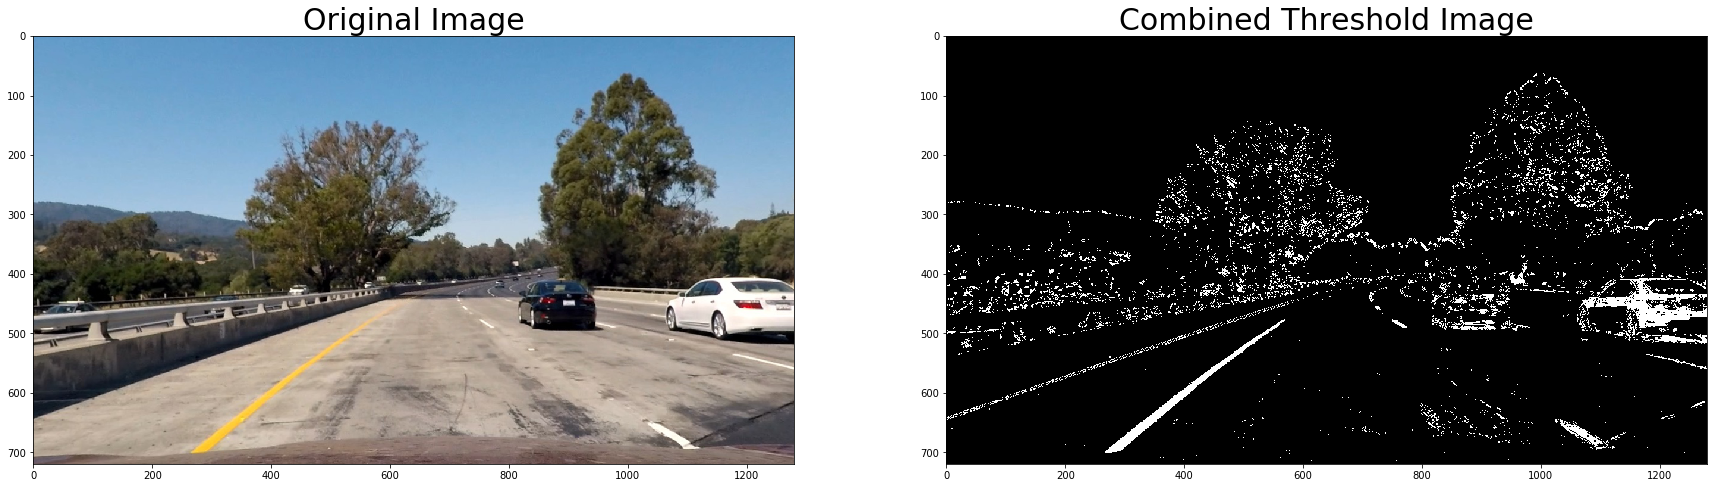

In [16]:
# Run the function
combined = threshold_combined(sobel_x, sobel_y, mag_binary, dir_binary, hls_binary)

# Show the result
print_images(img, 'Original Image', combined, 'Combined Threshold Image')
#mpimg.imsave('./output_images/Combined_Threshold_Image.jpg', combined)

In [17]:
# Define perspective transform function
def warp(img, src, dst):
    # Image Dimensions 
    img_size = (img.shape[1], img.shape[0])
    
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image, uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

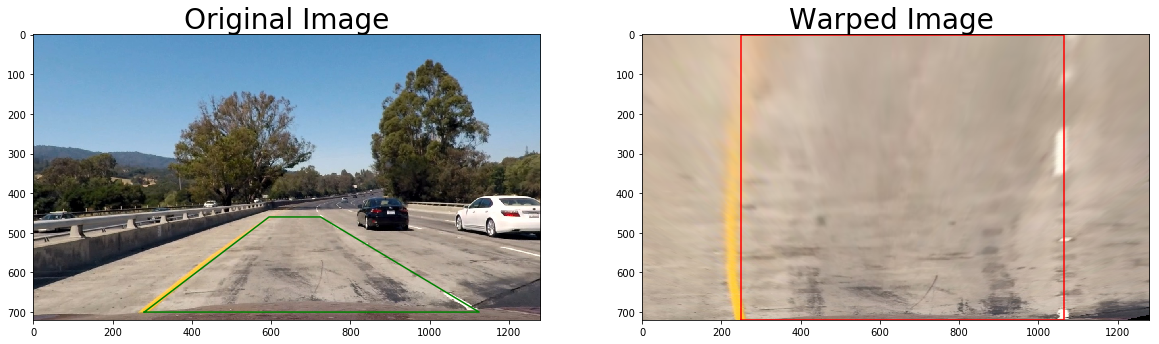

In [18]:
# src is a trapezoid that overlays the lane on the original image.
src = np.float32([[280,700],[595,460],[725,460],[1125,700]]) 
# dst is a rectangle that has t he same shape and orientation of the image itself.
dst = np.float32([[250,720],[250,0],[1065,0],[1065,720]]) 

warped_img, _ , Minv  = warp(img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image', fontsize=28)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='green')
ax1.imshow(img)

ax2.set_title('Warped Image ', fontsize=28)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)
#mpimg.imsave('./output_images/warped_img.jpg', warped_img)

## 5. Histogram and lane boundary

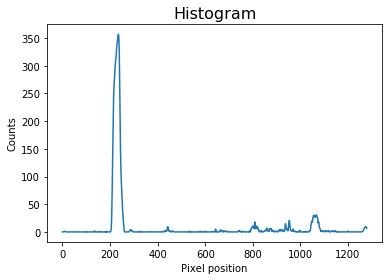

In [19]:
def histogr(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)

src = np.float32([[280,700],[595,460],[725,460],[1125,700]]) 
dst = np.float32([[250,720],[250,0],[1065,0],[1065,720]]) 

# Run de function over the combined warped image
combined_warped = warp(combined, src, dst)[0]
histogram = histogr(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)


In [20]:
def detect_lines(img, return_img=False):
    # Take a histogram of the bottom half of the image
    histogram = histogr(img)
    
    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
     
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    # y coordinates of all non zero pixels
    nonzeroy = np.array(nonzero[0])
    # x coordinates of all non zero pixels   
    nonzerox = np.array(nonzero[1])   

   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

In [21]:
# Run the function
lines_fit, left_points, right_points, out_img = detect_lines(combined_warped, return_img=True)
#print_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

In [22]:
def detect_similar_lines(img, line_fit=None, return_img=False):
    if line_fit is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fit[0]
    right_fit = line_fit[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
         
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img


In [23]:
lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, lines_fit, return_img=True)
#print_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

In [24]:
def find_curvature (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [25]:

# Run the function
curvature_rads = find_curvature(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)

# Print the results
print('Left Curve:', curvature_rads[0], 'm')
print('Right Curve:', curvature_rads[1], 'm')

Left Curve: 571.668111326 m
Right Curve: 966.308991067 m


In [26]:

def camera_offset(leftx, rightx, img_shape):
    xm_per_pix=3.7/800
    mid_imgx = img_shape[1]//2
    car_pos = (leftx[-1] + rightx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [27]:
# Run the function
offset = camera_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)

print ('Car offset from center:', offset, 'm')

Car offset from center: -0.057667591096 m


## 6. Detected lane boundaries back onto the original image.

In [28]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

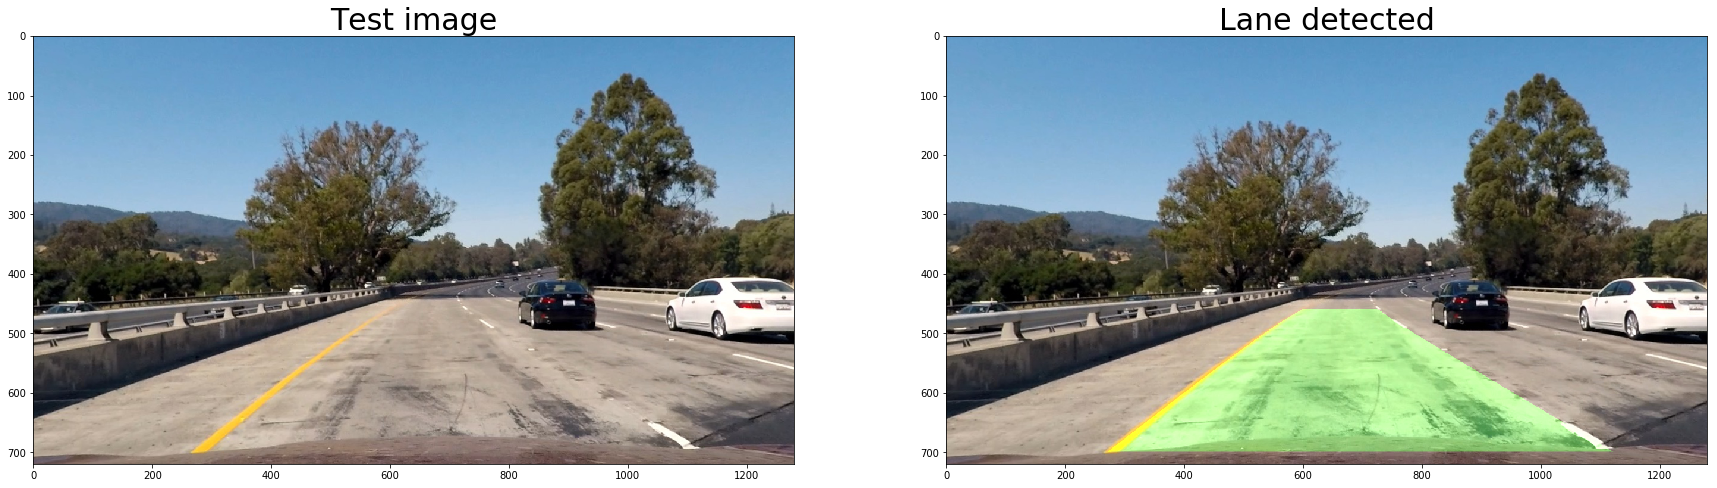

In [29]:
# Run the function
img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)

# Plot the results
print_images(img, 'Test image', img_lane, 'Lane detected')
#mpimg.imsave('./output_images/img_lane.jpg', img_lane)

## 7. Curvature and offset to the image

In [30]:
def add_info(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = find_curvature(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = camera_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Camera offset: {:.3f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

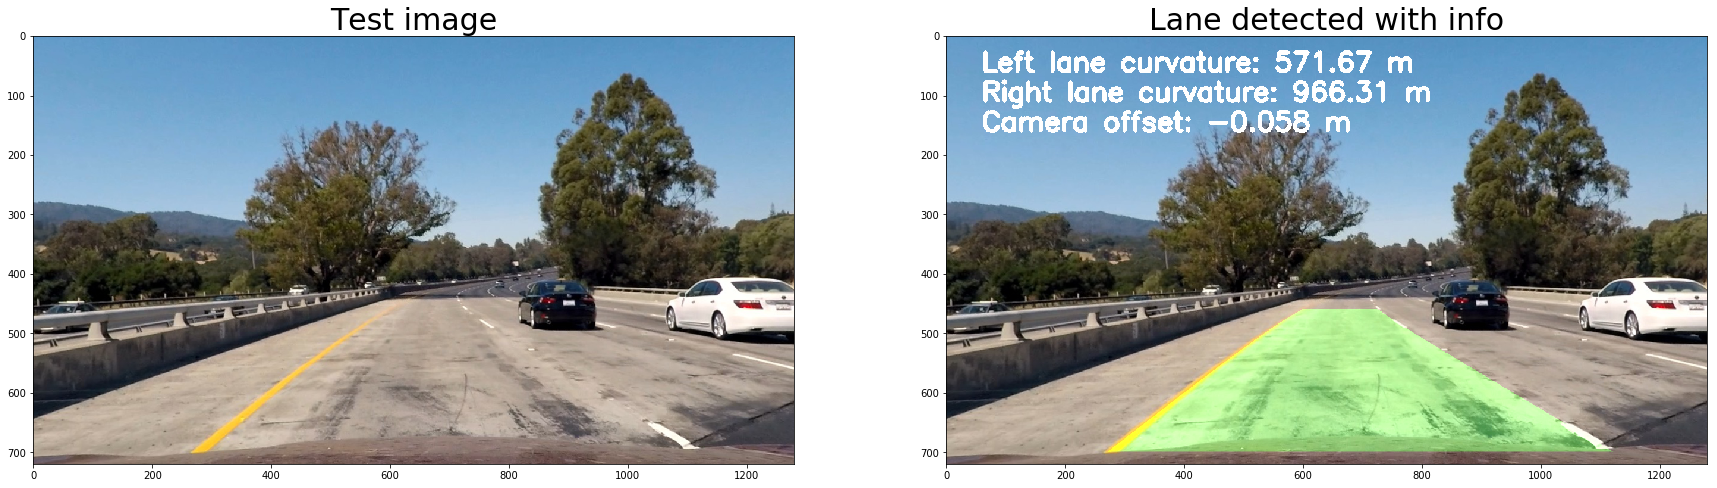

In [31]:
# Run the function
out_img = add_info(img_lane, leftx=left_points[0], rightx=right_points[0])

# Plot the results
print_images(img, 'Test image', out_img, 'Lane detected with info')
#mpimg.imsave('./output_images/Lane_detected_with_info', img_lane)

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
class ProcessImage:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None

    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient
        grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

        # Calculate gradient magnitude 
        mag_binary = mag_thres(img, sobel_kernel=15, thresh=(50, 100))

        # Calculate gradient direction
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        hls_binary = hls_thresh(img, thresh=(170, 255))

        # Combine all the thresholds to identify the lane lines
        combined = threshold_combined(sobel_x, sobel_y, mag_binary, dir_binary, hls_binary)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src = np.float32([[280,700],[595,460],[725,460],[1125,700]])

        dst = np.float32([[250,720],[250,0],[1065,0],[1065,720]])
        
        combined_warped, _, Minv = warp(combined, src, dst)
                
        self.lines_fit, left_points, right_points, out_img = detect_similar_lines(combined_warped, self.lines_fit, return_img=True)

        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)
            
        # Add metrics to the output img
        out_img = add_info(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img


In [34]:

input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessImage('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


100%|█████████▉| 1260/1261 [08:08<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 5min 21s, sys: 40.3 s, total: 6min 2s
Wall time: 8min 11s


In [35]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))